# 10. Logistic Regression

## 10.5 Bayesian logistic regression

### 10.5.1 Laplace approximation

> Author: Meduri Venkata Shivaditya

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Creating data
N = 30
D = 2

N_zeros = np.zeros(N)
N_ones = np.ones(N)

mu1 = np.stack((N_ones, 5 * N_ones), axis=1)  # mu1 = (1, 5) of shape (N, D)
mu2 = np.stack((-5 * N_ones, N_ones), axis=1) # mu2 = (-5, 1) of shape (N, D)

sigma1 = 1
sigma2 = 2.2

rng = np.random.default_rng(seed=12)
X1 = rng.normal(loc=mu1, scale=sigma1, size=(N, D)) # y = 1
X2 = rng.normal(loc=mu2, scale=sigma2, size=(N, D)) # y = 0

X = np.concatenate((X1, X2), axis=0)
y = np.concatenate((N_ones, N_zeros), axis=0)
X.shape, y.shape

((60, 2), (60,))

#### Figure 10.13: (a) Illustration of the data. (b) Log-likelihood for a logistic regression model. The line is drawn from the origin in the direction of the MLE (which is at infinity).

$$
\begin{align*}
\operatorname{LL}(w) &= \log p(\mathcal{D}|w) = \log\prod_n\operatorname{Ber}(y_n|\sigma(w^Tx_n)) \\
&= \sum_n \bigl[ y_n\log\sigma(w^Tx_n)-(1-y_n)\log\sigma(-w^Tx_n) \bigr] \\
&= \sum_n y_n(w^Tx_n) - \sum_n\log(1+\exp(w^Tx_n))
\end{align*}
$$

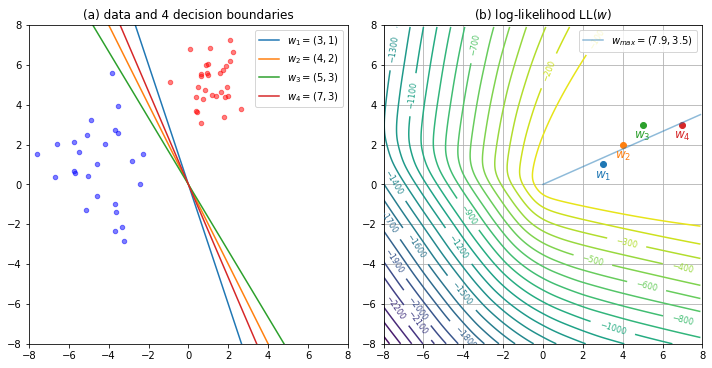

In [3]:
weights = np.array([[3, 1], [4, 2], [5, 3], [7, 3]])

lim = (-8, 8)
xs = np.arange(*lim, 0.1)
xx, yy = np.meshgrid(xs, xs)

W = np.stack((xx.ravel(), yy.ravel()), axis=1)
log_likelihood = np.dot(W @ X.T, y) - np.sum(np.log(1 + np.exp(W @ X.T)), axis=-1)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))

# (a) Plotting data

ax1.scatter(*X[y == 1].T, s=20, marker='o', color='red', alpha=0.5)
ax1.scatter(*X[y == 0].T, s=20, marker='o', color='blue', alpha=0.5)
for i, w in enumerate(weights):
    # decision boundary = -w[0] / w[1] = -b / w
    ax1.axline(
        xy1=(0, 0), slope=-w[0] / w[1], color=f'C{i}',
        label=f'$w_{i+1}=({w[0]},{w[1]})$'
    )
ax1.set_xlim(lim)
ax1.set_ylim(lim)
ax1.set_aspect('equal')
ax1.set_title('(a) data and 4 decision boundaries')
ax1.legend()

# (b) Plotting log-likelihood
cs = ax2.contour(xx, yy, log_likelihood.reshape(xx.shape), levels=30)
ax2.clabel(cs, inline=True, fontsize=8)
for i, w in enumerate(weights):
    ax2.plot(w[0], w[1], marker='o', color=f'C{i}')
    ax2.text(w[0], w[1]-0.25, f'$w_{i+1}$', color=f'C{i}', ha='center', va='top', fontsize=12)

w_max = W[np.argmax(log_likelihood)]
ax2.plot(
    (0, w_max[0]), (0, w_max[1]), alpha=0.5,
    label=f'$w_{{max}}=({w_max[0]:.1f}, {w_max[1]:.1f})$'
)
ax2.set_xlim(lim)
ax2.set_ylim(lim)
ax2.set_aspect('equal')
ax2.set_title('(b) log-likelihood $\operatorname{LL}(w)$')
ax2.grid(True)
ax2.legend()

# fig.colorbar(cs, ax=ax2)
fig.tight_layout()


#### Figure 10.13: (c) Unnormalized log posterior (assuming vague spherical prior). (d) Laplace approximation to posterior.

The (unnormalized) log posterior $\log p(\mathcal{D}|w) + \log p(w) \propto \log p(w|\mathcal{D})$, where the prior $p(w)=\mathcal{N}(w|0, 10^2I)$.

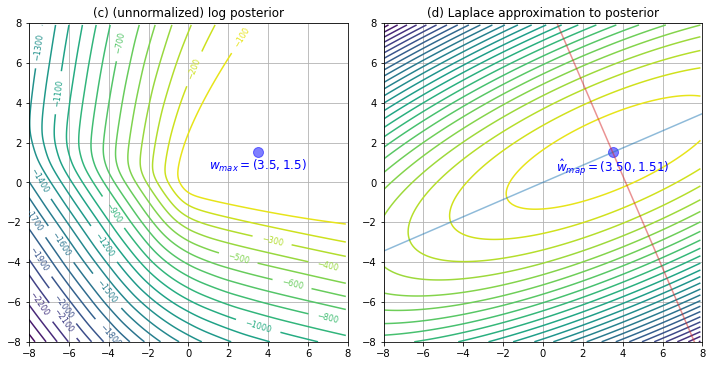

In [4]:
from scipy.stats import multivariate_normal
alpha = 10 ** 2
log_prior = -0.5 * np.sum((W @ np.identity(D) / alpha) * W, axis=-1)
#log_prior = np.log(multivariate_normal.pdf(W, cov=np.identity(D) * alpha))
log_joint = log_likelihood + log_prior

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))

# (c) Plotting the (unnormalised) log posterior

cs = ax1.contour(xx, yy, log_joint.reshape(xx.shape), levels=30)
ax1.clabel(cs, inline=True, fontsize=8)

w_max = W[np.argmax(log_joint)]
ax1.plot(
    w_max[0], w_max[1], marker='o', markersize=10, color='blue', alpha=0.5
)
ax1.text(
    w_max[0], w_max[1]-0.25, f'$w_{{max}}=({w_max[0]:.1f}, {w_max[1]:.1f})$',
    color='blue', ha='center', va='top', fontsize=12
)
ax1.set_xlim(lim)
ax1.set_ylim(lim)
ax1.set_aspect('equal')
ax1.set_title('(c) (unnormalized) log posterior')
ax1.grid(True)

# (d) Plotting the Laplace approximation to posterior

from scipy.special import expit
def f_nll_posterior(w, X, y, H):
    return -np.dot(w @ X.T, y) + np.sum(np.log(1 + np.exp(w @ X.T)), axis=-1) + 0.5 * np.dot(w @ H, w)

def g_nll_posterior(w, X, y, H):
    mu = expit(w @ X.T)
    return np.dot(X.T, (mu - y)) + w @ H

def H_nll_posterior(w, X, y, H):
    mu = np.expand_dims(expit(w @ X.T), axis=-1)
    return np.dot(X.T, X * (mu * (1 - mu))) + H

from scipy.optimize import minimize
w_prior = np.zeros(D)
H = np.identity(D) / alpha
ww = minimize(
    fun=f_nll_posterior, x0=w_prior, args=(X, y, H),
    method='Newton-CG', jac=g_nll_posterior, hess=H_nll_posterior,
    options={'maxiter': 100}
)
# hat_w represents the posterior parameters (MAP estimate)
# hat_H represents the posterior Hessian (Hessian of negative log posterior evaluated at MAP estimate)
hat_w = ww.x
hat_H = H_nll_posterior(hat_w, X, y, H)

log_laplace_posterior = np.log(
    multivariate_normal.pdf(W, mean=hat_w, cov=np.linalg.inv(hat_H))
)

cs = ax2.contour(xx, yy, log_laplace_posterior.reshape(xx.shape), levels=30)
# ax2.clabel(cs, inline=True, fontsize=8)
ax2.plot(
    hat_w[0], hat_w[1], marker='o', markersize=10, color='blue', alpha=0.5
)
ax2.text(
    hat_w[0], hat_w[1]-0.25, f'$\hat w_{{map}}=({hat_w[0]:.2f}, {hat_w[1]:.2f})$',
    color='blue', ha='center', va='top', fontsize=12
)
ax2.axline(xy1=(0, 0), xy2=hat_w, color='tab:blue', alpha=0.5)
ax2.axline(xy1=hat_w, slope=-hat_w[0] / hat_w[1], color='tab:red', alpha=0.5)
ax2.set_xlim(lim)
ax2.set_ylim(lim)
ax2.set_aspect('equal')
ax2.set_title('(d) Laplace approximation to posterior')
ax2.grid(True)

fig.tight_layout()